In [1]:
import sys
sys.path.insert(0, 'GCN/pygcn')

In [2]:
import numpy as np
import torch
import scipy
import math
import matplotlib.pyplot as plt
from torch import nn, optim
from pygcn.utils import accuracy
from torch.utils import data
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn.functional as F

In [3]:
from pygcn.utils import load_data
L, features, labels, idx_train, idx_val, idx_test = load_data(path='GCN/pygcn/data/cora/')

Loading cora dataset...


In [4]:
print(features.shape, L.shape, labels.shape, torch.max(labels))

torch.Size([2708, 1433]) torch.Size([2708, 2708]) torch.Size([2708]) tensor(6)


# Matrix functions
**Note**: Most of these functions must be changed as soon as torch will provide an implementation for them. At the moment (torch 1.3) most of these sparse functions are unavailable or not-well documented, hence the necessity of implementation below (that may be unefficent or not 100% correct)

In [ ]:
def sparse_degree_matrix(A) -> torch.sparse.FloatTensor:
    D = scipy.sparse.spdiags(torch.sparse.sum(A, dim=1).to_dense(),0, *A.shape).tocoo()
    return coo_to_torch_sparse_matrix(D)

In [ ]:
def coo_to_torch_sparse_matrix(coo):
    idx = torch.LongTensor(coo.nonzero())
    data = torch.FloatTensor(coo.data)
    return torch.sparse.FloatTensor(idx, data)

In [ ]:
def laplacian(A, normalized=True):
    I = torch.eye(A.shape[0])
    D = sparse_degree_matrix(A)
    if not normalized:
        L = D.sub(A)
    else:
        D = (D**(-(1/2))).to_dense()
        p1 = torch.spmm(A, D)
        p2 = torch.mm(p1, D)
        L = coo_to_torch_sparse_matrix(scipy.sparse.coo_matrix(I - p2))

    return L

<center><b>Sizes of variables</b>: </center>
$$L \in M^{2708\times 2708}$$
$$Features \in R^{2708\times 1433}$$
$$Labels \in N^{2708}$$
<center>Number of classes: 7</center>

# Cheb-Convnet

In [5]:
def test(model):
  y_pred = model(features, L) # Usiamo tutto il dataset
  acc_test = accuracy(y_pred[idx_test], labels[idx_test]) # Mascheriamo sulla parte di test
  print("Accuracy:",
          "accuracy= {:.4f}".format(acc_test.item()))

In [11]:
class Graph_Convolution_Chebychev(nn.Module):
        
        def __init__(self, F_in, F_out, K):
            super(Graph_Convolution_Chebychev, self).__init__()
            self.F_in = F_in
            self.F_out = F_out
            self.weight = Parameter(torch.FloatTensor(F_in * K, F_out))
            self.bias = Parameter(torch.FloatTensor(F_out))
            self.reset_parameters()

        def reset_parameters(self):
            stdv = 1. / math.sqrt(self.weight.size(1))
            self.weight.data.uniform_(-stdv, stdv)
            self.bias.data.fill_(0.0)
        
        def forward(self, x, L):
            V = x.size()[0];
            F_in = x.size()[1];
            
            x0 = x.contiguous()
            x0 = x0.view([V, F_in])
            x = x0.unsqueeze(0)

            if K > 1: 
                x1 = torch.spmm(L, x0)              # V x Fin
                x = torch.cat((x, x1.unsqueeze(0)),0)  # 2 x V x Fin
            for k in range(2, K):
                x2 = 2 * torch.spmm(L,x1) - x0  
                x = torch.cat((x, x2.unsqueeze(0)),0)  # M x Fin
                x0, x1 = x1, x2  

            x = x.view([K, V, F_in])           # K x V x Fin     
            x = x.permute(2,0,1).contiguous()  # V x Fin x K       
            x = x.view([V, F_in*K])             # V x Fin*K

            x = torch.mm(x, self.weight)
            return x + self.bias

In [15]:
class Chebychev_convolutional_network(nn.Module):
    
    def __init__(self, net_parameters):
        super(Chebychev_convolutional_network, self).__init__()

        self.F_in, self.F_out, self.K, self.dropout = net_parameters
        self.GCN1 = Graph_Convolution_Chebychev(self.F_in, 50, K)
        self.GCN2 = Graph_Convolution_Chebychev(50, 20, K)
        
        self.FC1 = nn.Linear(20, 128)
        scale = 1. / math.sqrt(self.FC1.weight.size(1))
        self.FC1.weight.data.uniform_(-scale, scale)
        self.FC1.bias.data.fill_(0.0)
        self.FC2 = nn.Linear(128, 7)
        scale = 1. / math.sqrt(self.FC2.weight.size(1))
        self.FC2.weight.data.uniform_(-scale, scale)
        self.FC2.bias.data.fill_(0.0)
        
    def forward(self, x, L):
        x = F.relu(self.GCN1(x, L))
        # x = self.graph_max_pool(x, 4)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.GCN2(x, L)
        # x = self.graph_max_pool(x, 4)
        # x = x.view(-1, self.FC1Fin)
        x = self.FC1(x)
        x = F.relu(x)
        x  = F.dropout(x, self.dropout, training=self.training)
        x = self.FC2(x)
        
        return F.log_softmax(x, dim=1)
    
    def graph_max_pool(self, x, p): 
        if p > 1: 
            x = x.view([x.size()[0], x.size()[1], 1])
            x = x.permute(0,2,1).contiguous()  # x = B x F x V
            x = nn.MaxPool1d(p)(x)             # B x F x V/p          
            x = x.permute(0,2,1).contiguous()  # x = B x V/p x F
            return x  
        else:
            return x   
    
    def loss(self, y, y_target, l2_regularization):
    
        loss = nn.CrossEntropyLoss()(y,y_target)

        l2_loss = 0.0
        for param in self.parameters():
            data = param* param
            l2_loss += data.sum()
           
        loss += 0.5* l2_regularization* l2_loss
            
        return loss

In [16]:
F_in = 1433
F_out = 7
K = 5
dropout = 0.2
net_parameters = [F_in, F_out, K, dropout]

cheb_net = Chebychev_convolutional_network(net_parameters)
optimizer_cheb = optim.Adam(cheb_net.parameters())
criterion = nn.CrossEntropyLoss()
test(cheb_net)

Accuracy: accuracy= 0.1410


In [20]:
import tqdm
loss_history = np.zeros(100) 

for epoch in tqdm.trange(100): 
  
    optimizer_cheb.zero_grad()
    outputs = cheb_net(features, L) # Usiamo tutto il dataset
    loss = criterion(outputs, labels) # Mascheriamo sulla parte di training
    loss.backward()
    optimizer_cheb.step()
    optimizer_cheb.zero_grad()

    loss_history[epoch] = loss.detach().numpy()

100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


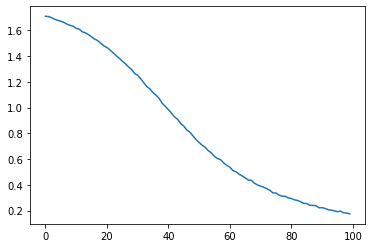

Accuracy: accuracy= 0.9570
tensor(0.1737, grad_fn=<NllLossBackward>)


In [21]:
plt.plot(loss_history)
plt.show()
test(cheb_net)
print(loss)